#Notebook KNN5: Fake-Bilder (Generative Adversarial Network)

In diesem Notebook lassen wir wieder ein neuronales Netz (den Diskriminator) den MNIST-Datensatz erlernen. Zudem wird im Lernprozess ein zweites neuronales Netz (der Generator) versuchen, das erste Netz mit "Fake-Bildern" zu täuschen.

Dieses Modell heißt GAN (='Generative Adversarial Network' ‚ also ein generatives gegnerisches Netzwerk). 


Als Ergebnis erhält man so neue Bilder von handgeschriebenen Ziffern, die künstlich produziert wurden.





Der Code stammt vollständig von https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN. 
Wir verwenden das dort beschriebene DCGAN-Modell (deep convolutional GAN).


Diese Notebook ist technisch anspruchsvoller. Besuchen Sie die Seite https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN und versuchen Sie, das DCGAN-Modell zu verstehen.

In [0]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

# G(z)
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

    return o
  
# D(x)
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

    return o, conv5
  
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(7, 7))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
      
      
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
      
        
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

In [0]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 10

# load MNIST
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

In [0]:
# variables : input
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST resize and normalization
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5 # normalization; range: -1 ~ 1

In [0]:
print# results save folder
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(mnist.train.num_examples // batch_size):
        # update discriminator
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)
        

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

#sess.close()

training start!
[1/3] - ptime: 350.88 loss_d: 0.834, loss_g: 5.188
[2/3] - ptime: 347.39 loss_d: 0.668, loss_g: 2.859
[3/3] - ptime: 347.29 loss_d: 0.575, loss_g: 3.678
Avg per epoch ptime: 348.52, total 3 epochs ptime: 1048.70
Training finish!... save training results


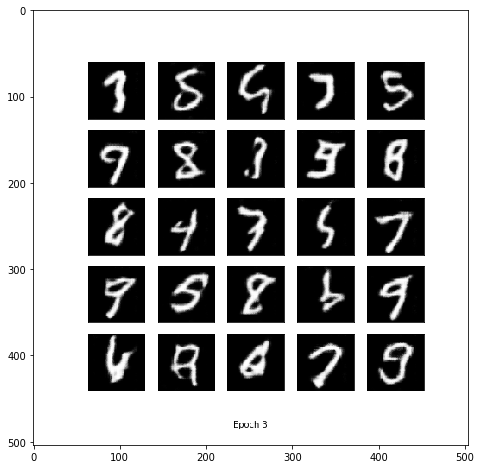

In [0]:
# 25 random pictures of the GAN

fig = plt.figure(figsize=(8, 8))
plt.imshow(images[train_epoch-1],cmap='Greys',vmin=0, vmax=255)
plt.show()


Save the gif file in google Drive:

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls "/content/drive/My Drive"

imageio.mimsave('/content/drive/My Drive/' + model + 'generation_animation.gif', images, fps=5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'	       KNN_Notebooks_Kopie   trade
 DCGAN_epochs.gif	       KNN_Skript	     zuzu.gif
 DCGAN_supervised_epochs.gif   Loewner
 KNN_Notebooks		       MNIST-one_layer.py


Generate pictures from new noise:

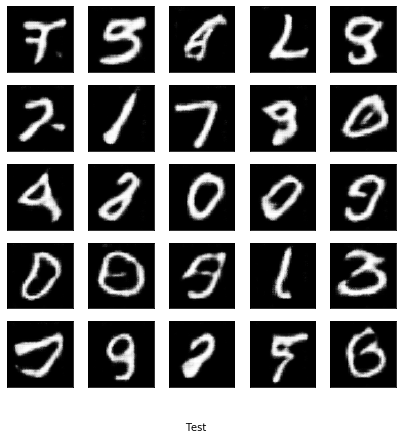

In [0]:
random_noise = np.random.normal(0, 1, (25, 1, 1, 100))
test_images = sess.run(G_z, {z: random_noise, isTrain: False})

size_figure_grid = 5
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(7, 7))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for k in range(size_figure_grid*size_figure_grid):
    i = k // size_figure_grid
    j = k % size_figure_grid
    ax[i, j].cla()
    ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')
label = 'Test'
fig.text(0.5, 0.04, label, ha='center')

plt.show()